In [2]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.style.use("default")
font = {'size'   : 16}
plt.rc('font', **font)

In [3]:
def parseTiming(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Braid" in line: continue
            if "wall time" in line: return float(line.split()[-1])
    raise Exception("Reached end of file!")

def parseTol(fname, tol):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Begin" in line: continue
            if "not available" in line: continue
            if "Solver Stats" in line: continue
            if "Braid" in line and "wall time" in line:
                res = float(line.split()[5].split(',')[0])
                if res <= tol:
                    return float(line.split()[-1])

def parseIters(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "max iterations" in line: continue
            if "Max" in line: continue
            if "iterations" in line: return float(line.split()[-1])

In [11]:
ncores = (8, 64, 512, 4096)
mlevels = (3, 4, 5, 6)
serials = np.zeros(len(ncores))
thetas = np.zeros(len(ncores))
deltas = np.zeros(len(ncores))
mgrits = np.zeros(len(ncores))
bad_pts = []
tol = 1e-6

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    serials[i] = parseTiming(f"ks_nc{nc}_ml1")
    thetas[i] = parseTol(f"ks_theta_nc{nc}_ml{ml}", tol)
    deltas[i] = parseTol(f"ks_Delta_nc{nc}_ml{ml}", tol)
    mgrits[i] = parseTol(f"ks_nc{nc}_ml{ml}", tol)

    if np.isnan(thetas[i]):
        thetas[i] = parseTiming(f"ks_theta_nc{nc}_ml{ml}")
        bad_pts.append((nc, thetas[i]))
    if np.isnan(deltas[i]):
        deltas[i] = parseTiming(f"ks_Delta_nc{nc}_ml{ml}")
        bad_pts.append((nc, deltas[i]))
    if np.isnan(mgrits[i]):
        mgrits[i] = parseTiming(f"ks_nc{nc}_ml{ml}")
        bad_pts.append((nc, mgrits[i]))

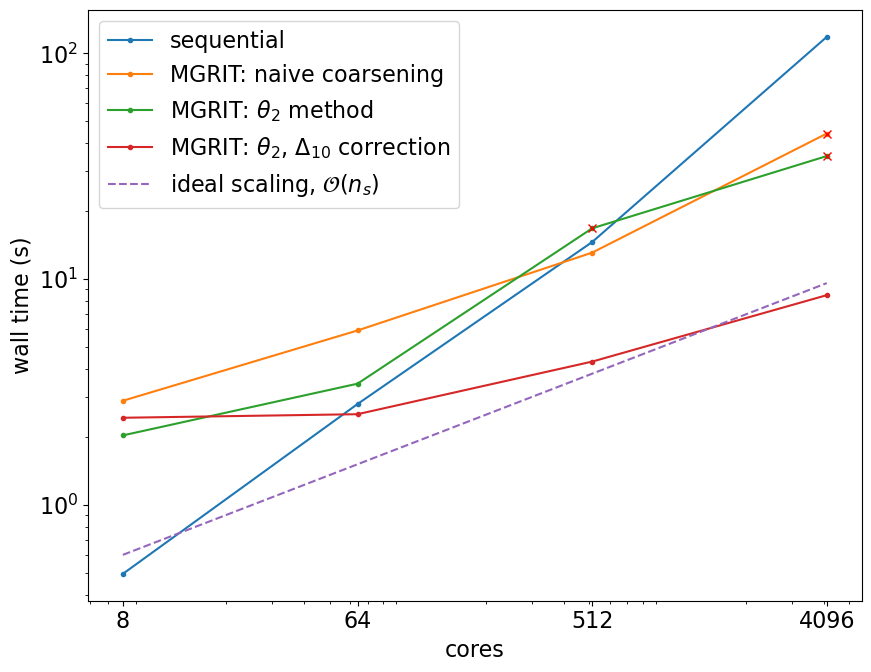

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
ax.loglog(ncores, serials, '.-', label="sequential")
ax.loglog(ncores, mgrits, '.-', label="MGRIT: naive coarsening")
ax.loglog(ncores, thetas, '.-', label=r"MGRIT: $\theta_2$ method")
ax.loglog(ncores, deltas, '.-', label=r"MGRIT: $\theta_2$, $\Delta_{10}$ correction")
ax.plot((ncores[0], ncores[-1]), (6e-1, 6e-1*2**len(ncores)), '--', label=r"ideal scaling, $\mathcal{O}(n_s)$")
[ax.plot(*pt, 'rx') for pt in bad_pts]
ax.set_xlabel("cores")
ax.set_ylabel("wall time (s)")
ax.legend()
plt.xticks(ncores, ncores)
plt.tight_layout()
plt.savefig("weak_scaling_KS_refinement.png", dpi=300)

In [10]:
mgrits

array([ 2.89,  5.92, 13.1 ,   nan])

In [7]:
1/(deltas[-1]/serials[-1])

13.949486925795052

In [13]:
serials[-2]/deltas[-2]

3.3864939675174015